In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import os
import cv2
import time

from torch.autograd import Variable
from torch.utils.data import DataLoader,random_split
from torchvision import datasets, models, transforms
from torch.nn import functional as F
from PIL import Image
from tqdm import tqdm

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

DATA = {
    'train': 'drive/My Drive/KAGGLE/data/train/training_set',
    'test': 'drive/My Drive/KAGGLE/data/test/test_set'
}


cuda:0


In [2]:
lengths_cat = len(os.listdir(os.path.join(DATA['train'],'cats')))
lengths_dog = len(os.listdir(os.path.join(DATA['train'],'dogs')))
print(lengths_cat,lengths_dog)
lengths = [6000,2005]

4001 4006


In [3]:
IMG_SIZE = 224

normalize = transforms.Normalize(
    mean = (0.485, 0.456, 0.406),
    std = (0.229, 0.224, 0.225)
)

data_transforms = transforms.Compose([
                                      transforms.Resize((IMG_SIZE,IMG_SIZE)),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.RandomRotation(10),
                                      transforms.ToTensor(),
                                      normalize
])



In [4]:
BATCH_SIZE = 32
data = datasets.ImageFolder(DATA['train'],transform = data_transforms)
train_data, val_data = random_split(data,lengths)


train_loader = DataLoader(train_data,batch_size=BATCH_SIZE,shuffle = True, num_workers= 4)
val_loader = DataLoader(val_data,batch_size=BATCH_SIZE,shuffle = False, num_workers= 4)


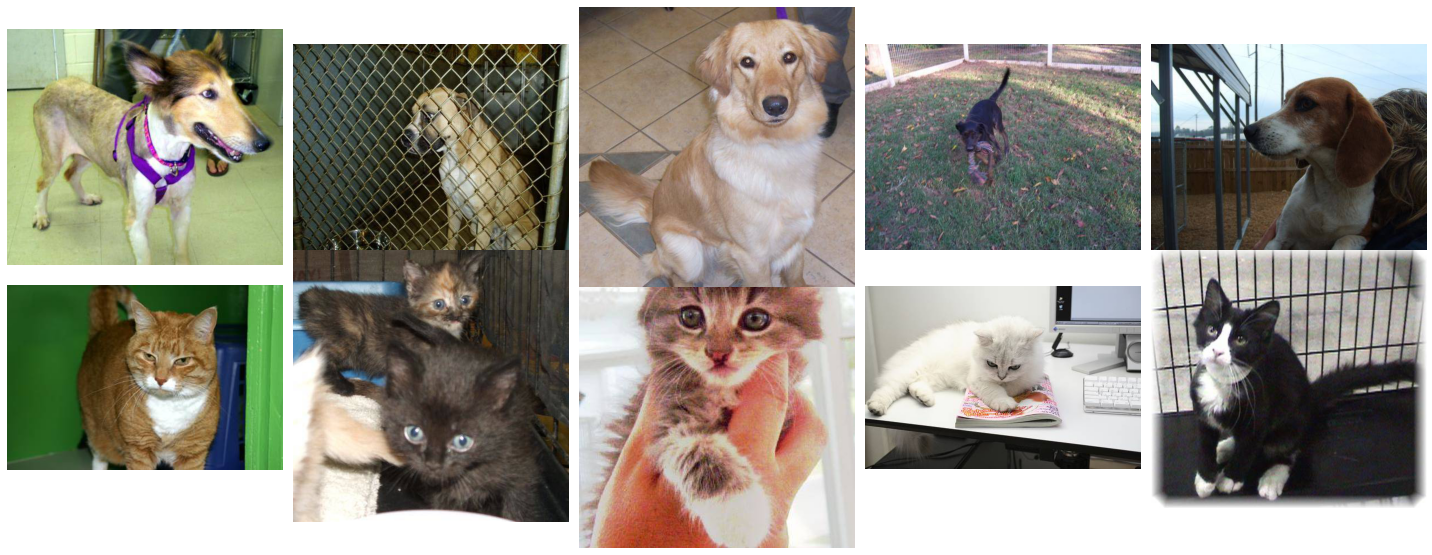

In [5]:
def display_images(data):
    data_cats = os.path.join(data,'cats')
    data_dogs =os.path.join(data,'dogs')

    cats_path = os.listdir(data_cats)
    dogs_path = os.listdir(data_dogs)

    rand = np.random.randint(2500)
    num_imgs = 5
    
    fig = plt.figure(figsize = (20,14))
    for i, id in enumerate(cats_path[rand: rand + num_imgs]):
        img = Image.open(os.path.join(data_cats, id))
        fig.add_subplot(1,num_imgs, i + 1)
        plt.axis('off')
        plt.imshow(img)
    
    for i, id in enumerate(dogs_path[rand: rand + num_imgs]):
        img = Image.open(os.path.join(data_dogs, id))
        fig.add_subplot(2,num_imgs, i + 1)
        plt.axis('off')
        plt.imshow(img)
    
    plt.tight_layout()
    plt.show()

display_images(DATA['train'])


In [6]:
resnet = models.resnet50(pretrained = True).to(device)

for param in resnet.parameters():
    param.requires_grad = False

resnet.fc = nn.Sequential(
    nn.Linear(2048, 128),
    nn.ReLU(inplace = True),
    nn.Linear(128,2)
).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet.parameters(), lr = 1e-4)

dataloader = {
    'train': train_loader,
    'val': val_loader
}

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


In [7]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(resnet):,} parameters')

The model has 262,530 parameters


In [8]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [9]:
EPOCHS = 25

def train_model(model, dataloader, optimizer, criterion, num_epochs = EPOCHS):
    train_loss_list = []
    train_acc_list = []
    val_loss_list = []
    val_acc_list = []
    best_acc = 0.0
    dataloader_size = {'train': len(dataloader['train'].dataset),
                       'val': len(dataloader['val'].dataset)}
    print('------------------ Start trainning -------------------')
    for epoch in range(num_epochs):
        start_time = time.time()

        for mode in ['train', 'val']:
            if mode == 'train':
                model.train()
            
            else:
                model.eval()
            
            running_loss = 0.0
            running_acc = 0.0

            for images, labels in dataloader[mode]:
                images = images.to(device)
                labels = labels.to(device)

                outputs = model(images)
                loss = criterion(outputs, labels)
                if mode == 'train':
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()
                
                preds = torch.max(outputs, 1)[1]
                running_loss += loss.item()
                running_acc += (preds == labels).sum()
            
            if mode == 'train':
                train_epoch_loss = running_loss /dataloader_size[mode]
                train_loss_list.append(train_epoch_loss)

                train_epoch_acc = float(running_acc) / dataloader_size[mode]
                train_acc_list.append(train_epoch_acc)
            else:
                val_epoch_loss = running_loss /dataloader_size[mode]
                val_loss_list.append(val_epoch_loss)

                val_epoch_acc = float(running_acc) / dataloader_size[mode]
                val_acc_list.append(val_epoch_acc)
            
            if mode == 'val' and val_epoch_acc > best_acc:
                best_acc = val_epoch_acc
                torch.save(model.state_dict(),'model/model.pt')
        
        end_time = time.time()
        epoch_mins, epoch_secs = epoch_time(start_time, end_time)

        print(f'Epoch: [{epoch + 1: 02}/{num_epochs}] | Epoch Time: {epoch_mins}m {epoch_secs}s')
        print(f'\t\t Train Loss: {train_epoch_loss :.4f} | Train Acc: {train_epoch_acc: .4f}')
        print(f'\t\t Val Loss: {val_epoch_loss :.4f} | Val Acc: {val_epoch_acc: .4f}')

    model.load_state_dict(torch.load('model/model.pt'))        
    return model, train_loss_list, val_loss_list, train_acc_list, val_acc_list




In [10]:
start_time = time.time()

model, train_loss_list, val_loss_list, train_acc_list, val_acc_list = train_model(resnet,dataloader,optimizer,criterion,num_epochs=10)

end_time = time.time()
mins, secs = epoch_time(start_time, end_time)
print(f'Total traning time: {mins}m {secs}s')

------------------ Start trainning -------------------
Epoch: [ 1/10] | Epoch Time: 13m 44s
		 Train Loss: 0.0064 | Train Acc:  0.9403
		 Val Loss: 0.0026 | Val Acc:  0.9726
Epoch: [ 2/10] | Epoch Time: 0m 44s
		 Train Loss: 0.0029 | Train Acc:  0.9668
		 Val Loss: 0.0021 | Val Acc:  0.9776
Epoch: [ 3/10] | Epoch Time: 0m 44s
		 Train Loss: 0.0025 | Train Acc:  0.9718
		 Val Loss: 0.0023 | Val Acc:  0.9746
Epoch: [ 4/10] | Epoch Time: 0m 45s
		 Train Loss: 0.0022 | Train Acc:  0.9753
		 Val Loss: 0.0016 | Val Acc:  0.9791
Epoch: [ 5/10] | Epoch Time: 0m 44s
		 Train Loss: 0.0021 | Train Acc:  0.9745
		 Val Loss: 0.0017 | Val Acc:  0.9786
Epoch: [ 6/10] | Epoch Time: 0m 45s
		 Train Loss: 0.0023 | Train Acc:  0.9723
		 Val Loss: 0.0015 | Val Acc:  0.9820
Epoch: [ 7/10] | Epoch Time: 0m 45s
		 Train Loss: 0.0018 | Train Acc:  0.9780
		 Val Loss: 0.0015 | Val Acc:  0.9800
Epoch: [ 8/10] | Epoch Time: 0m 45s
		 Train Loss: 0.0021 | Train Acc:  0.9747
		 Val Loss: 0.0015 | Val Acc:  0.9800


# Because the fluctuations is not high so the model is still good in this dog_cat_classifier 

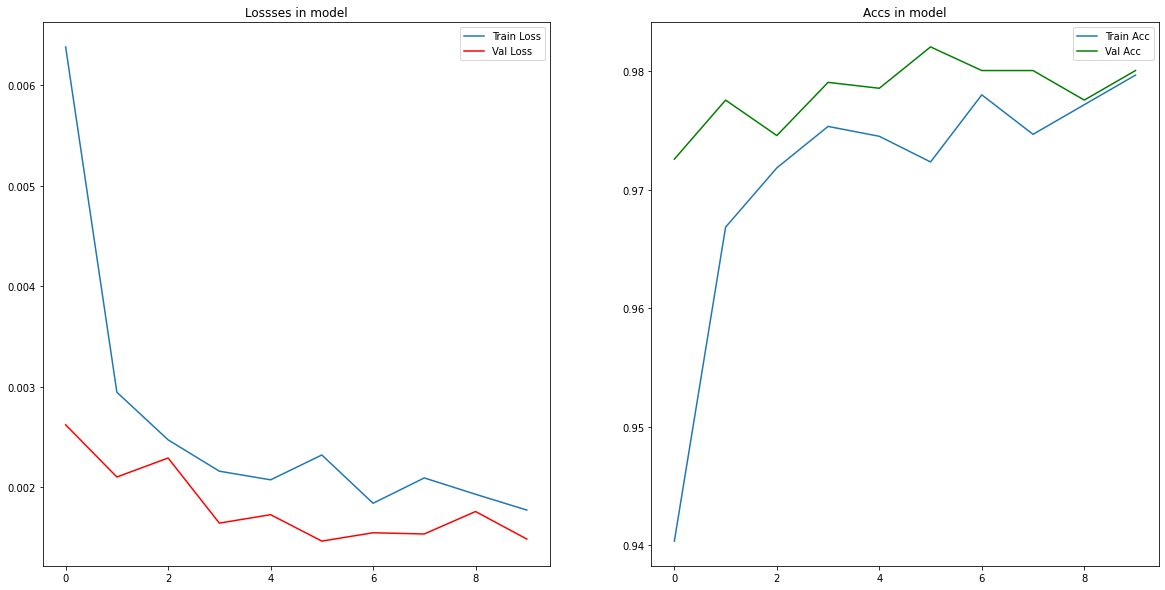

In [11]:
def plot_curves( train_loss_list, val_loss_list, train_acc_list, val_acc_list):
    fig = plt.figure(figsize = (20,10))
    # fig 1 - Loss
    fig.add_subplot(1,2,1)
    plt.plot(range(10),train_loss_list, label = 'Train Loss')
    plt.plot(range(10),val_loss_list, label = 'Val Loss', color = 'red')
    plt.legend()
    plt.title('Lossses in model')

    #fig 2 - Acc
    fig.add_subplot(1,2,2)
    plt.plot(range(10),train_acc_list, label = 'Train Acc')
    plt.plot(range(10),val_acc_list, label = 'Val Acc', color = 'green')
    plt.legend()
    plt.title('Accs in model')

plot_curves(train_loss_list, val_loss_list, train_acc_list, val_acc_list)

In [12]:
def predict_images(model, images):
    model.eval()

    with torch.no_grad():
        test = Variable(images).view(-1,3,IMG_SIZE,IMG_SIZE)
        test = test.to(device)

        outputs= model(test)
        preds = torch.max(outputs.data, 1)[1]
    
    return preds.cpu().numpy()[0]

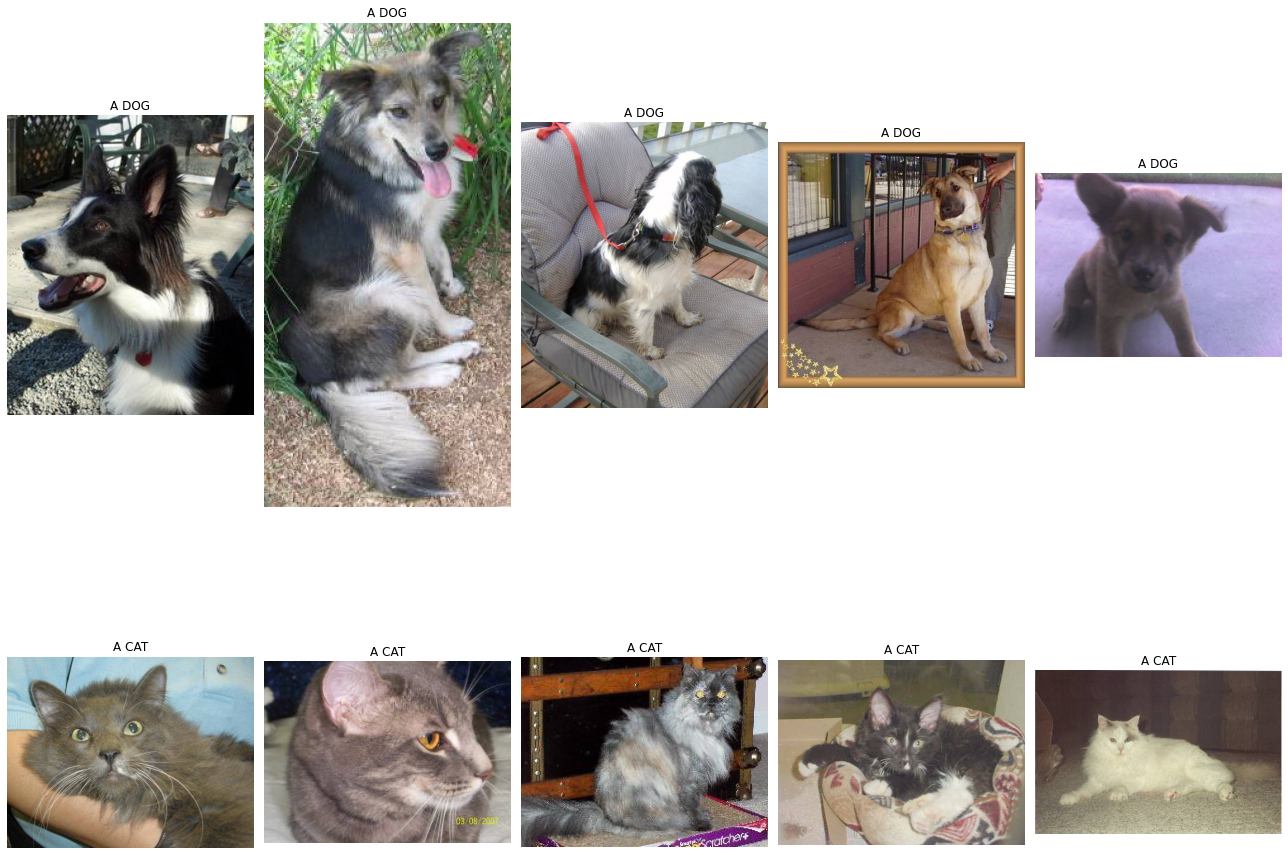

In [13]:
def visualize_test_images(model, data, num_imgs = 10):
    data_cats = os.path.join(data,'cats')
    data_dogs =os.path.join(data,'dogs')

    cats_path = os.listdir(data_cats)
    dogs_path = os.listdir(data_dogs)

    columns = 5
    rand = np.random.randint(len(cats_path))
    fig = plt.figure(figsize = (18,30))

    for i, lab in enumerate(cats_path[rand: rand+ num_imgs//2]):
        img = Image.open(os.path.join(data_cats, lab))
        img_transform = data_transforms(img)

        outputs = predict_images(model, img_transform)
        fig.add_subplot(1, columns, i + 1)
        plt.imshow(img)
        plt.axis('off')
        plt.title('A CAT' if outputs == 0 else 'A DOG')

    for i, lab in enumerate(dogs_path[rand: rand+ num_imgs//2]):
        img = Image.open(os.path.join(data_dogs, lab))
        img_transform = data_transforms(img)

        outputs = predict_images(model, img_transform)
        fig.add_subplot(2, columns, i + 1)
        plt.imshow(img)
        plt.axis('off')
        plt.title('A CAT' if outputs == 0 else 'A DOG')

    plt.tight_layout()
    plt.show()

visualize_test_images(model, DATA['test'], 10)